In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import IPython.display

tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))


Eager execution: True


In [2]:
x = [[2.]]
m = tf.matmul(x, x)
print("run in eager mode: {}".format(m))

run in eager mode: [[4.]]


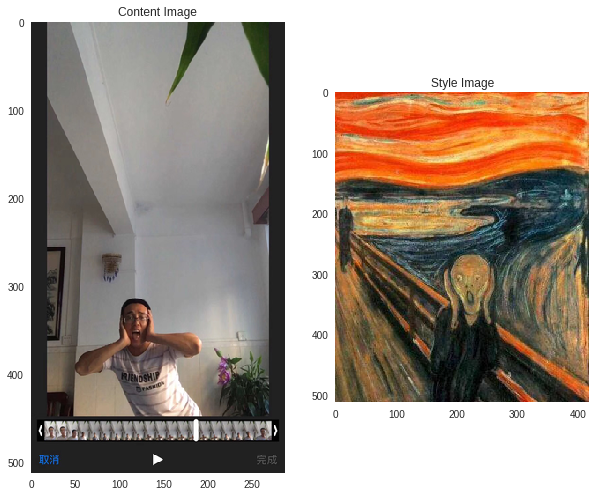

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools
from tensorflow.python.keras.preprocessing import image as kp_image


content_path =  '/content/gdrive/My Drive/content.JPG'
style_path =  '/content/gdrive/My Drive/style.JPG'



#加载和显示图片
def  load_img(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim / long
  img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)),
                  Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  return img

def  show_img(img, title = None):
  out = np.squeeze(img, axis = 0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
    
  plt.imshow(out)
  
plt.figure(figsize = (10, 10))
content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')
plt.subplot(1, 2, 1)
show_img(content, 'Content Image')

plt.subplot(1, 2, 2)
show_img(style, 'Style Image')
plt.show()

In [0]:
def  load_and_process_img(path):
  img = load_img(path)
  '''
  使用vgg19卷积网络对图片进行识别前需要进行预处理，它把像素点RGB的值分别减去103.99,116.779,
  123.68，然后把RGB格式转为BGR格式
  '''
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

#定义用于进行内容调整的卷积层
content_layers = ['block5_conv2']
#定义用于风格计算的卷积层,这几层是实践发现效果最好的卷积层
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
def  get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def  gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])

In [0]:
def  gram_matrix(input_tensor):
  #获得卷积层计算后的’深度‘
  channels = int(input_tensor.shape[-1])
  '''
  这里的-1相当于把卷积层对应的平面拉成一条直线,假设卷积层运算后得到的三维向量为[w, h, d],
  d对应上面的channel，下面reshape后，三维向量变成二维向量[w*h, d]
  '''
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  #将第i行与第j行做点乘得到个莱姆矩阵的第(i,j)个元素
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)

#更加公式（4）计算风格差异
def  get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  '''
  这里我们没有像公式（4）去乘以1/(4*N^2*M^2),工程实践上不用除效果更好
  '''
 
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [0]:
def  get_feature_representations(model, content_path, style_path):
  '''
  把内容图片和风格图片输入到VGG19网络，然后获取相应卷积层的计算结果
  '''
  content_img = load_and_process_img(content_path)
  style_img = load_and_process_img(style_path)
  
  style_outputs = model(style_img)
  content_outputs = model(content_img)
  
  #抽取风格图片对应的卷积层输出
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  
  return style_features, content_features

In [0]:
def  compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  '''
  init_image对应白色图片，我们通过公式（2）和公式(6)计算像素点如何相对于内容和风格去调整，
  然后根据公式(7)修改白色图片像素点的值
  '''
  style_weight, content_weight = loss_weights
  
 
  #计算白色图片对应卷积层的输出
  model_outputs = model(init_image)
  #获得白色图片对应风格卷积层的计算结果
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0
  
  #计算风格对应卷积层的权重
  weight_per_style_layer = 1.0 / float(num_style_layers)
  #根据公式(6)计算差值
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  #根据公式(2)计算内容差值
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0],
                                                                target_content)
    
    
  #根据公式(7)计算像素点的调节
  style_score *= style_weight
  content_score *= content_weight
  
  loss = style_score + content_score
  
  return loss, style_score, content_score

In [0]:
def  compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    #根据差值反向对像素点求偏导
    gradient = tape.gradient(total_loss, cfg['init_image'])
    return gradient, all_loss

In [0]:
'''
图片输入VGG19网络时曾经进行特定处理，因此图片要想正常显示就需要进行相应的反处理
'''
def  deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert(len(x.shape) == 3)
  
  #将VGG19对图片像素点的预处理还原回来
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  #把BGR格式转回RGB格式
  x = x[:, :, ::-1]
  
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def  run_style_transfer(content_path, style_path,
                       num_iterations = 1000, 
                       content_weight = 1e3,
                       style_weight = 1e-2):
  model = get_model()
  #我们要调整的是输入图片的像素点而不调VGG19卷积网络的参数
  for layer in model.layers:
    layer.trainable = False
  
  #把内容图片和风格图片输入VGG网络获取对应卷积层的计算结果
  style_features, content_features = get_feature_representations(model, content_path,
                                                                style_path)
  #计算风格图片对应卷积层的格莱姆矩阵
  gram_style_features = [gram_matrix(style_feature) for
                        style_feature in style_features]
  #这里我们直接把照片作为白色画布来使用
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype = tf.float32)
  #选择优化方法
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1 = 0.99, epsilon = 1e-1)
  
  iter_count = 1
  best_loss, best_img = float('inf'), None
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model' : model,
      'loss_weights' : loss_weights,
      'init_image' : init_image,
      'gram_style_features' : gram_style_features,
      'content_features' : content_features
  }
  
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations / (num_rows * num_cols)
  start_time = time.time()
  global_start = time.time()
  #由于图片输入VGG网络时做过预处理，这里准备把运算结果反预处理后显示出来
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    #修改像素点的值
    init_image.assign(clipped)
    end_time = time.time()
    

    if loss < best_loss:
      best_loss = loss
      #输入vgg网络的图片都经过特定预处理,因此我们要把它输出的结果做反处理后才能显示出来
      best_img = deprocess_img(init_image.numpy())
      
    if i % display_interval == 0:
      start_time = time.time()
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      
      IPython.display.clear_output(wait = True)
      IPython.display.display_png(Image.fromarray(plot_img))
      
      print('Iteration: {}'.format(i))
      print('Total loss: {: .4e}, style loss: {: .4e},'
            ' content loss: {: .4e}, time: {: .4f}s'.format(loss, style_score,
                                                           content_score,
                                                           time.time() - start_time))
      print('Total time: {:.4f}s'.format(time.time() - global_start))
      
    
        
  return best_img, best_loss

    
  

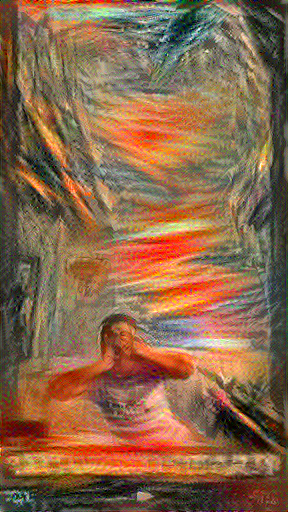

Iteration: 900
Total loss:  8.9428e+05, style loss:  2.8497e+05, content loss:  6.0931e+05, time:  0.0549s
Total time: 196.6550s


(array([[[ 20,  57,  10],
         [ 84,  91,  74],
         [ 63,  73,  32],
         ...,
         [106, 124,  92],
         [108, 137,  63],
         [107, 137,  76]],
 
        [[ 77,  73,  45],
         [ 65,  73,  30],
         [ 75,  90,  20],
         ...,
         [ 94, 107, 109],
         [ 99, 121,  89],
         [103, 125,  93]],
 
        [[101,  75,  22],
         [ 82,  68,  23],
         [ 80,  76,  33],
         ...,
         [ 91, 107,  94],
         [ 99, 109,  86],
         [ 84, 102,  93]],
 
        ...,
 
        [[ 39, 168, 152],
         [130, 114, 100],
         [120,  74,  84],
         ...,
         [101,  18,  59],
         [ 86,  67,  10],
         [109,  52,  50]],
 
        [[ 94, 134, 104],
         [ 85, 107,  80],
         [ 96,  91,  99],
         ...,
         [102,  57,  28],
         [115,  70,   0],
         [156,  46,   1]],
 
        [[177, 164, 151],
         [147, 122, 111],
         [129, 105, 116],
         ...,
         [107,  56,  11],
  

In [20]:
run_style_transfer(content_path, style_path, num_iterations = 1000)